# Description

This notebook the TPC ADC distribution histograms produced by the RawWaveform (???) analyzer module
 and calculates conservative TP rate estimates based on the ADC distribution quantiles, and vice versa.

# Setup

In [5]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
import tpvalidator.mcprod.workspace as workspace
# import tpvalidator.utilities as utils
import tpvalidator.mcprod.analyzers.snn as snn
import mplhep as hep
import matplotlib.pyplot as plt
import hist

from rich import print
import rich
rich.get_console().is_jupyter = False

from tpvalidator.utilities import temporary_log_level, pandas_backend
from tpvalidator.histograms import hist_mean_std, hist_quantiles


## Code

In [7]:
def uproot_to_hist(h):
    hh = h.to_hist()
    hh.name = h.name
    hh.label = h.title
    return hh

In [18]:
def print_quantiles_table(h, p: dict):

    from rich.table import Table
    
    prob=np.array(list(p.values()))

    # y=0.
    # xq=np.array([0.]*len(prob))

    xq = hist_quantiles(h, prob)
    h_mean, h_std = hist_mean_std(h)[0]
    
    # h.GetQuantiles(len(prob),xq,prob)

    # cols = [str(i) for i in range(len(prob)+1)]
    # cols = ['']+list(p.keys())
    t = Table(title=h.label)
    t.add_column("value", min_width=20)
    for k in p:
        t.add_column(k)
    # h_std = h.GetStdDev()
    # t = Table(*cols, title=h.GetName())
    t.add_row(*(['input prob']+ [f"{1-p:.3e}" for p in prob]))
    t.add_row(*(['x vals (adcs)']+ [f"{x:.2f}" for x in xq]))
    t.add_row(*(['dist from mean (adcs)']+ [f"{x:.2f}" for x in (xq-xq[0])]))
    t.add_row(*(['dist from mean (68% units)', '-']+ [f"{x:.2f}" for x in (xq-xq[0])[1:]/(xq[1]-xq[0])]))
    t.add_row(*(['dist from mean (std)', '-']+ [f"{x:.2f}" for x in (xq-xq[0])[1:]/h_std]))


    c = rich.get_console()
    c.is_jupyter = True
    c.width = 200

    print(t)

In [ ]:

def plot_adc_hist_right_tail(h: hist.Hist, thr: int, win_size: int) -> plt.Figure:
    """Plots histogram, its stats highlighting the right tail

    Args:
        h (hist.Hist): The histogram to plot
        thr (int): Threshold
        win_size (int): display window size

    Returns:
        plt.Figure: Resulting figure
    """

    stat_x = 0.95
    stat_y = 0.95
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    fig, ax = plt.subplots()

    h_mean, h_std = hist_mean_std(h)[0]
    x_axis = h.axes[0]

    m = x_axis.index(h_mean)
    p = x_axis.index(h_mean+thr)

    # Histogram, line only
    hep.histplot(h[m-win_size:m+win_size], label="all adcs", linewidth=2, yerr=False, ax=ax)


    # Histogram
    # Make a copy and zero all bins below threshold
    hh = h.copy()
    hh[:p] = 0

    hep.histplot(hh[m-win_size:m+win_size], label=f"adcs > {h_mean+thr:.0f}", linewidth=2, yerr=False, ax=ax, histtype='fill')


    textstr = '\n'.join((
        f'$\\mu={h_mean:.2f}$',
        f'$\\sigma={h_std:.2f}$'))

    # place a text box in top center in axes coords
    ax.text(stat_x, stat_y, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right', bbox=props)
    

    # Decorations
    ax.set_title("Noise Hist, plane X")
    ax.set_xlabel("adc")
    ax.set_ylabel("counts")
    ax.set_yscale("log")
    ax.legend()

    fig.tight_layout()

    return fig

# Argon 39

## Load ADC mean and standard deviation from wafevorm histograms

In [8]:
dataset_info = {
    'readout_window' : 8500
}

with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.INFO):
    ar39_ws = workspace.TriggerPrimitivesWorkspace("../../data/vd/ar39/100events/trigtree_tpg_vd_ar39.root", extra_info=dataset_info)

print(ar39_ws.info)

INFO:TriggerPrimitivesWorkspace:tpmakerTPCSimpleThreshold__TriggerPrimitiveMaker found with 72540769 rows


{
    'backtracker': {'TPAlgTPCSimpleThreshold': {'offset_U': 8, 'offset_V': 1, 'offset_X': -7}},
    'geo': {'detector': 'dunevd10kt_3view_30deg_v5_refactored_1x8x6ref'},
    'tpg': {
        'tpmakerTPCSimpleThreshold::TriggerPrimitiveMaker': {
            'threshold_tpg_plane0': 23,
            'threshold_tpg_plane1': 23,
            'threshold_tpg_plane2': 26,
            'tool': 'TPAlgTPCSimpleThreshold'
        }
    }
}


In [9]:
ar39_ws.add_rawdigits('../../data/vd/ar39/100events/trigger_digits_waves_detsim_vd_ar39.root')

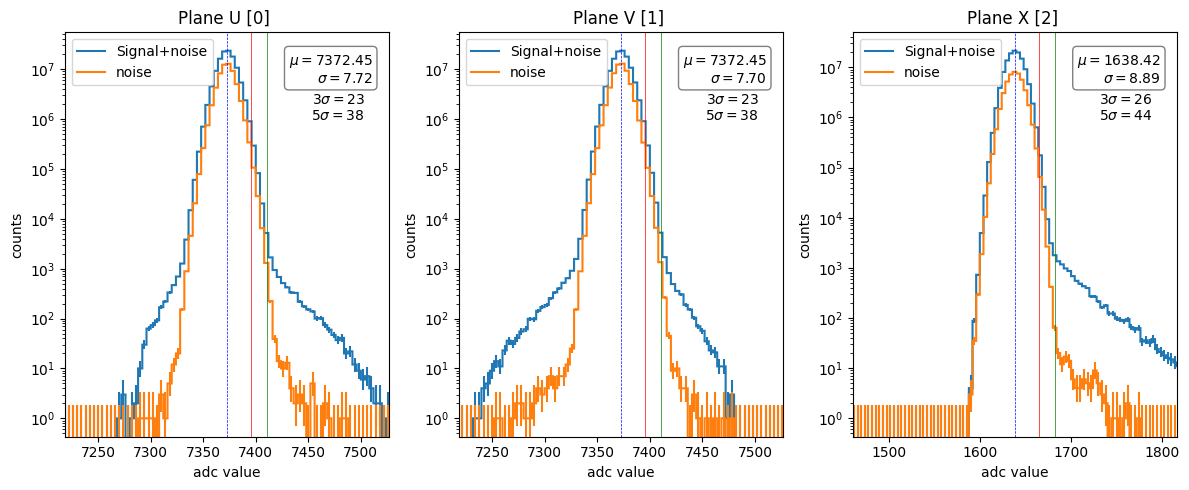

In [10]:
fig = snn.draw_signal_and_noise_adc_distros(ar39_ws)
fig.tight_layout()

## Starting here

In [12]:
h_adc_u = uproot_to_hist(ar39_ws.rawdigits_hists['ADCsPlaneU'])
h_adc_v = uproot_to_hist(ar39_ws.rawdigits_hists['ADCsPlaneV'])
h_adc_x = uproot_to_hist(ar39_ws.rawdigits_hists['ADCsPlaneX'])

h_adc_noise_u = uproot_to_hist(ar39_ws.rawdigits_hists['ADCsNoisePlaneU'])
h_adc_noise_v = uproot_to_hist(ar39_ws.rawdigits_hists['ADCsNoisePlaneV'])
h_adc_noise_x = uproot_to_hist(ar39_ws.rawdigits_hists['ADCsNoisePlaneX'])

In [13]:
print(hist_mean_std(h_adc_noise_x))
print(hist_mean_std(h_adc_noise_u))
print(hist_mean_std(h_adc_noise_v))

{0: (np.float64(1638.4210663159872), np.float64(8.886371849042572))}
{0: (np.float64(7372.453364187853), np.float64(7.718895885737156))}
{0: (np.float64(7372.450513719266), np.float64(7.70472195876674))}


In [14]:
def calc_pval_noise(h, rate_noise_tps = 2):
    sampl_period = 0.5e-6 # s
    # num_noise = int(h.GetEntries())
    num_noise = int(h.integrate(0))
    t_sampl = num_noise*sampl_period # s
    n_exp_noise_tps = rate_noise_tps*t_sampl
    p_val_noise_tps = n_exp_noise_tps/num_noise
    quantile = 1-p_val_noise_tps


    #-----
    print(f"---hist '{h.label}'---" )
    print(f"num noise adcs = {num_noise}")
    print(f"sampling period = {t_sampl} s")
    print(f"target noise rate = {rate_noise_tps} Hz")
    print(f"num expected noise adcs = {n_exp_noise_tps}")
    print(f"p_val_noise = {p_val_noise_tps}")
    print(f"quantile = {quantile}")
    print()



calc_pval_noise(h_adc_noise_u, 100)
calc_pval_noise(h_adc_noise_v, 100)
calc_pval_noise(h_adc_noise_x, 100)

---hist 'ADCs on plane U'---
num noise adcs = 58684000
sampling period = 29.342 s
target noise rate = 100 Hz
num expected noise adcs = 2934.2
p_val_noise = 4.9999999999999996e-05
quantile = 0.99995

---hist 'ADCs on plane X'---
num noise adcs = 58913500
sampling period = 29.45675 s
target noise rate = 100 Hz
num expected noise adcs = 2945.675
p_val_noise = 5e-05
quantile = 0.99995

---hist 'ADCs on plane X'---
num noise adcs = 45245500
sampling period = 22.62275 s
target noise rate = 100 Hz
num expected noise adcs = 2262.275


p_val_noise = 5e-05
quantile = 0.99995



In [ ]:

prob=np.array([0.5, 0.841, 0.977, 0.998, 0.9999685, 0.99999985, 0.9999974370002747, 0.999999, 0.999995, 0.99995])

prob_d = {
    'mean':  0.5,
    '1-sig': 0.841,
    '2-sig': 0.977, 
    '3-sig': 0.998, 
    '4-sig': 0.9999685, 
    '5-sig': 0.99999985, 
    'coll-ref': 0.9999974370002747, 
    '2 Hz': 0.999999,
    '10 Hz': 0.999995,
    '100 Hz': 0.99995
}

print_quantiles_table(h_adc_noise_x, prob_d)
print_quantiles_table(h_adc_noise_u, prob_d)
print_quantiles_table(h_adc_noise_x, prob_d)


                                                                   ADCs on plane X                                                                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ value                      ┃ mean      ┃ 1-sig     ┃ 2-sig     ┃ 3-sig     ┃ 4-sig     ┃ 5-sig     ┃ coll-ref  ┃ 2 Hz      ┃ 10 Hz     ┃ 100 Hz    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│ input prob                 │ 5.000e-01 │ 1.590e-01 │ 2.300e-02 │ 2.000e-03 │ 3.150e-05 │ 1.500e-07 │ 2.563e-06 │ 1.000e-06 │ 5.000e-06 │ 5.000e-05 │
│ x vals (adcs)              │ 1638.41   │ 1647.34   │ 1656.00   │ 1663.88   │ 1674.76   │ 1738.43   │ 1684.21   │ 1706.75   │ 1679.57   │ 1673.50   │
│ dist from mean (adcs)      │ 0.00      │ 8.93      │ 17.58     │ 25.46     │ 36.34     │ 100.01    │ 45.79     │ 68.34     │ 41.15     │ 35.08     │
│ dist from mean (68% units) │ -         │ 1.00      │ 1.97      │ 2.85      │ 4.07      │ 11.20     │ 5.13      │ 7.65      │ 4.61      │ 3.93      │
│ dist from mean (std)       │ -         │ 1.00      │ 1.98      │ 2.87      │ 4.09      │ 11.25     │ 5.15      │ 7.69      │ 4.63      │ 3.95      │
└────────────────────────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

                                                                   ADCs on plane U                                                                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ value                      ┃ mean      ┃ 1-sig     ┃ 2-sig     ┃ 3-sig     ┃ 4-sig     ┃ 5-sig     ┃ coll-ref  ┃ 2 Hz      ┃ 10 Hz     ┃ 100 Hz    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│ input prob                 │ 5.000e-01 │ 1.590e-01 │ 2.300e-02 │ 2.000e-03 │ 3.150e-05 │ 1.500e-07 │ 2.563e-06 │ 1.000e-06 │ 5.000e-06 │ 5.000e-05 │
│ x vals (adcs)              │ 7372.47   │ 7379.75   │ 7388.32   │ 7396.96   │ 7407.86   │ 7452.96   │ 7415.05   │ 7419.93   │ 7412.49   │ 7407.20   │
│ dist from mean (adcs)      │ 0.00      │ 7.28      │ 15.85     │ 24.49     │ 35.39     │ 80.49     │ 42.58     │ 47.46     │ 40.02     │ 34.73     │
│ dist from mean (68% units) │ -         │ 1.00      │ 2.18      │ 3.36      │ 4.86      │ 11.06     │ 5.85      │ 6.52      │ 5.50      │ 4.77      │
│ dist from mean (std)       │ -         │ 0.94      │ 2.05      │ 3.17      │ 4.59      │ 10.43     │ 5.52      │ 6.15      │ 5.19      │ 4.50      │
└────────────────────────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

                                                                   ADCs on plane X                                                                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ value                      ┃ mean      ┃ 1-sig     ┃ 2-sig     ┃ 3-sig     ┃ 4-sig     ┃ 5-sig     ┃ coll-ref  ┃ 2 Hz      ┃ 10 Hz     ┃ 100 Hz    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│ input prob                 │ 5.000e-01 │ 1.590e-01 │ 2.300e-02 │ 2.000e-03 │ 3.150e-05 │ 1.500e-07 │ 2.563e-06 │ 1.000e-06 │ 5.000e-06 │ 5.000e-05 │
│ x vals (adcs)              │ 1638.41   │ 1647.34   │ 1656.00   │ 1663.88   │ 1674.76   │ 1738.43   │ 1684.21   │ 1706.75   │ 1679.57   │ 1673.50   │
│ dist from mean (adcs)      │ 0.00      │ 8.93      │ 17.58     │ 25.46     │ 36.34     │ 100.01    │ 45.79     │ 68.34     │ 41.15     │ 35.08     │
│ dist from mean (68% units) │ -         │ 1.00      │ 1.97      │ 2.85      │ 4.07      │ 11.20     │ 5.13      │ 7.65      │ 4.61      │ 3.93      │
│ dist from mean (std)       │ -         │ 1.00      │ 1.98      │ 2.87      │ 4.09      │ 11.25     │ 5.15      │ 7.69      │ 4.63      │ 3.95      │
└────────────────────────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

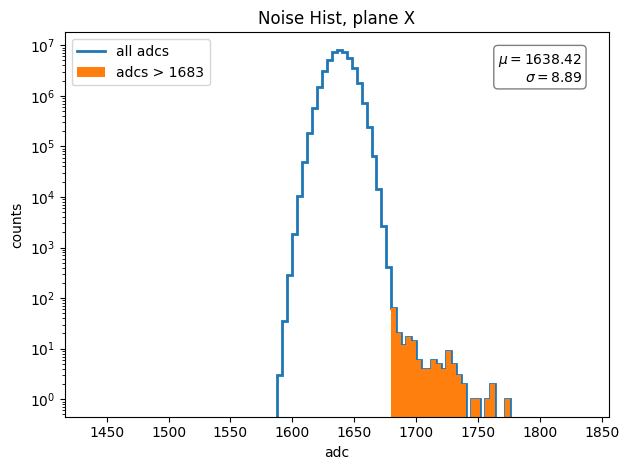

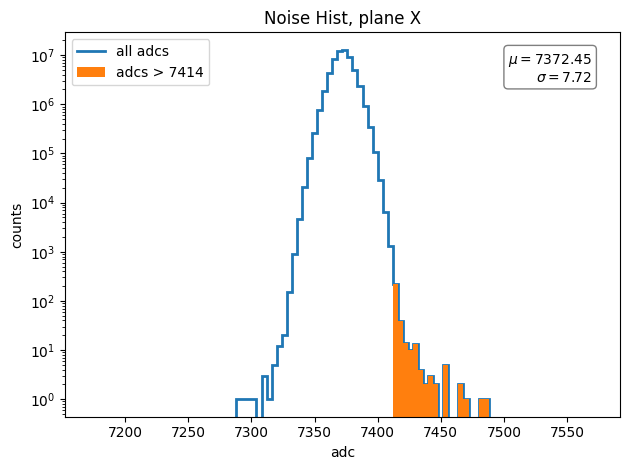

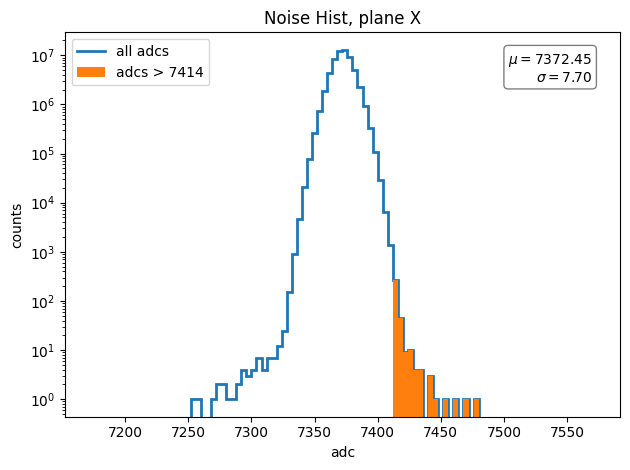

In [ ]:
_ = plot_adc_hist_right_tail(h_adc_noise_x, 45, 50)
_ = plot_adc_hist_right_tail(h_adc_noise_u, 42, 50)
_ = plot_adc_hist_right_tail(h_adc_noise_v, 42, 50)


# Ar39 - Pre-production


INFO:TriggerPrimitivesWorkspace:Opening Trigger Primitives file
INFO:TriggerPrimitivesWorkspace:Adding processing info
INFO:TriggerPrimitivesWorkspace:Adding Event Summary data
INFO:TriggerPrimitivesWorkspace:triggerAna/event_summary found with 100 rows
INFO:TriggerPrimitivesWorkspace:Adding MCTruth data
INFO:TriggerPrimitivesWorkspace:triggerAna/mctruths found with 1499716 rows
INFO:TriggerPrimitivesWorkspace:Adding MCNeutrino data
INFO:TriggerPrimitivesWorkspace:triggerAna/mcneutrinos found with 0 rows
INFO:TriggerPrimitivesWorkspace:Adding MCParticles data
INFO:TriggerPrimitivesWorkspace:triggerAna/mcparticles found with 1499716 rows
INFO:TriggerPrimitivesWorkspace:Adding IDEs data
INFO:TriggerPrimitivesWorkspace:triggerAna/simides found with 31180442 rows
INFO:TriggerPrimitivesWorkspace:tpmakerTPCSimpleThreshold__TriggerPrimitiveMaker found with 393091 rows


{
    'backtracker': {'TPAlgTPCSimpleThreshold': {'offset_U': 8, 'offset_V': 1, 'offset_X': -7}},
    'geo': {'detector': 'dunevd10kt_3view_30deg_v5_refactored_1x8x6ref'},
    'tpg': {'tpmakerTPCSimpleThreshold::TriggerPrimitiveMaker': {'threshold_tpg_plane0': 45, 'threshold_tpg_plane1': 45, 'threshold_tpg_plane2': 45, 'tool': 'TPAlgTPCSimpleThreshold'}}
}

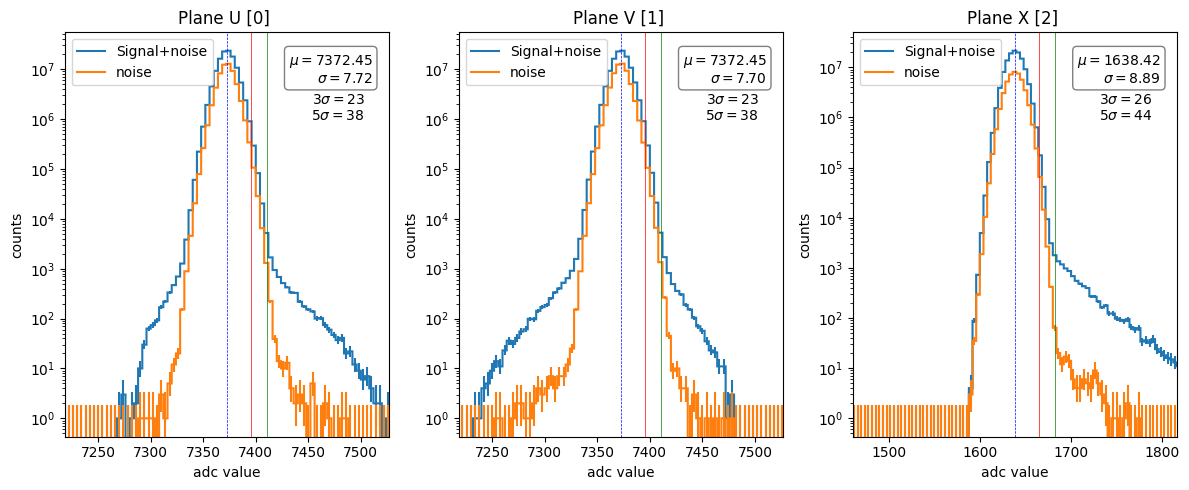

In [17]:
dataset_info = {
    'readout_window' : 8500
}

with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.INFO):
    ar39_ws = workspace.TriggerPrimitivesWorkspace("../../data/vd/pre_prod/anatree_vd_ar39_hist.root", extra_info=dataset_info)

print(ar39_ws.info)
ar39_ws.add_rawdigits('../../data/vd/pre_prod/rawdigits/trigger_digits_hists_detsim_vd_ar39.root')
fig = snn.draw_signal_and_noise_adc_distros(ar39_ws)
fig.tight_layout()

In [20]:
h_adc_u = uproot_to_hist(ar39_ws.rawdigits_hists['ADCsPlaneU'])
h_adc_v = uproot_to_hist(ar39_ws.rawdigits_hists['ADCsPlaneV'])
h_adc_x = uproot_to_hist(ar39_ws.rawdigits_hists['ADCsPlaneX'])

h_adc_noise_u = uproot_to_hist(ar39_ws.rawdigits_hists['ADCsNoisePlaneU'])
h_adc_noise_v = uproot_to_hist(ar39_ws.rawdigits_hists['ADCsNoisePlaneV'])
h_adc_noise_x = uproot_to_hist(ar39_ws.rawdigits_hists['ADCsNoisePlaneX'])

In [21]:
print(hist_mean_std(h_adc_noise_x))
print(hist_mean_std(h_adc_noise_u))
print(hist_mean_std(h_adc_noise_v))

{0: (np.float64(1638.4210663159872), np.float64(8.886371849042572))}

{0: (np.float64(7372.453364187853), np.float64(7.718895885737156))}

{0: (np.float64(7372.450513719266), np.float64(7.70472195876674))}

In [27]:
def calc_pval_noise(h, rate_noise_tps = 2):
    sampl_period = 0.5e-6 # s
    # num_noise = int(h.GetEntries())
    num_noise = int(h.integrate(0))
    t_sampl = num_noise*sampl_period # s
    n_exp_noise_tps = rate_noise_tps*t_sampl
    p_val_noise_tps = n_exp_noise_tps/num_noise
    quantile = 1-p_val_noise_tps


    #-----
    print(f"""
---hist '{h.label}'---
num noise adcs = {num_noise}
sampling period = {t_sampl} s
target noise rate = {rate_noise_tps} Hz
num expected noise adcs = {n_exp_noise_tps}
p_val_noise = {p_val_noise_tps:.2e}
quantile = {quantile}
""")


calc_pval_noise(h_adc_noise_u, 100)
calc_pval_noise(h_adc_noise_v, 100)
calc_pval_noise(h_adc_noise_x, 100)

---hist 'ADCs on plane U'---
num noise adcs = 58684000
sampling period = 29.342 s
target noise rate = 100 Hz
num expected noise adcs = 2934.2
p_val_noise = 5.00e-05
quantile = 0.99995

---hist 'ADCs on plane X'---
num noise adcs = 58913500
sampling period = 29.45675 s
target noise rate = 100 Hz
num expected noise adcs = 2945.675
p_val_noise = 5.00e-05
quantile = 0.99995

---hist 'ADCs on plane X'---
num noise adcs = 45245500
sampling period = 22.62275 s
target noise rate = 100 Hz
num expected noise adcs = 2262.275
p_val_noise = 5.00e-05
quantile = 0.99995

In [ ]:

prob=np.array([0.5, 0.841, 0.977, 0.998, 0.9999685, 0.99999985, 0.9999974370002747, 0.999999, 0.999995, 0.99995])

prob_d = {
    'mean':  0.5,
    '1-sig': 0.841,
    '2-sig': 0.977, 
    '3-sig': 0.998, 
    '4-sig': 0.9999685, 
    '5-sig': 0.99999985, 
    'coll-ref': 0.9999974370002747, 
    '2 Hz': 0.999999,
    '10 Hz': 0.999995,
    '100 Hz': 0.99995
}


print_quantiles_table(h_adc_noise_x, prob_d)
print_quantiles_table(h_adc_noise_u, prob_d)
print_quantiles_table(h_adc_noise_x, prob_d)


                                                                   ADCs on plane X                                                                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ value                      ┃ mean      ┃ 1-sig     ┃ 2-sig     ┃ 3-sig     ┃ 4-sig     ┃ 5-sig     ┃ coll-ref  ┃ 2 Hz      ┃ 10 Hz     ┃ 100 Hz    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│ input prob                 │ 5.000e-01 │ 1.590e-01 │ 2.300e-02 │ 2.000e-03 │ 3.150e-05 │ 1.500e-07 │ 2.563e-06 │ 1.000e-06 │ 5.000e-06 │ 5.000e-05 │
│ x vals (adcs)              │ 1638.41   │ 1647.34   │ 1656.00   │ 1663.88   │ 1674.76   │ 1738.43   │ 1684.21   │ 1706.75   │ 1679.57   │ 1673.50   │
│ dist from mean (adcs)      │ 0.00      │ 8.93      │ 17.58     │ 25.46     │ 36.34     │ 100.01    │ 45.79     │ 68.34     │ 41.15     │ 35.08     │
│ dist from mean (68% units) │ -         │ 1.00      │ 1.97      │ 2.85      │ 4.07      │ 11.20     │ 5.13      │ 7.65      │ 4.61      │ 3.93      │
│ dist from mean (std)       │ -         │ 1.00      │ 1.98      │ 2.87      │ 4.09      │ 11.25     │ 5.15      │ 7.69      │ 4.63      │ 3.95      │
└────────────────────────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

                                                                   ADCs on plane U                                                                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ value                      ┃ mean      ┃ 1-sig     ┃ 2-sig     ┃ 3-sig     ┃ 4-sig     ┃ 5-sig     ┃ coll-ref  ┃ 2 Hz      ┃ 10 Hz     ┃ 100 Hz    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│ input prob                 │ 5.000e-01 │ 1.590e-01 │ 2.300e-02 │ 2.000e-03 │ 3.150e-05 │ 1.500e-07 │ 2.563e-06 │ 1.000e-06 │ 5.000e-06 │ 5.000e-05 │
│ x vals (adcs)              │ 7372.47   │ 7379.75   │ 7388.32   │ 7396.96   │ 7407.86   │ 7452.96   │ 7415.05   │ 7419.93   │ 7412.49   │ 7407.20   │
│ dist from mean (adcs)      │ 0.00      │ 7.28      │ 15.85     │ 24.49     │ 35.39     │ 80.49     │ 42.58     │ 47.46     │ 40.02     │ 34.73     │
│ dist from mean (68% units) │ -         │ 1.00      │ 2.18      │ 3.36      │ 4.86      │ 11.06     │ 5.85      │ 6.52      │ 5.50      │ 4.77      │
│ dist from mean (std)       │ -         │ 0.94      │ 2.05      │ 3.17      │ 4.59      │ 10.43     │ 5.52      │ 6.15      │ 5.19      │ 4.50      │
└────────────────────────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

                                                                   ADCs on plane X                                                                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ value                      ┃ mean      ┃ 1-sig     ┃ 2-sig     ┃ 3-sig     ┃ 4-sig     ┃ 5-sig     ┃ coll-ref  ┃ 2 Hz      ┃ 10 Hz     ┃ 100 Hz    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│ input prob                 │ 5.000e-01 │ 1.590e-01 │ 2.300e-02 │ 2.000e-03 │ 3.150e-05 │ 1.500e-07 │ 2.563e-06 │ 1.000e-06 │ 5.000e-06 │ 5.000e-05 │
│ x vals (adcs)              │ 1638.41   │ 1647.34   │ 1656.00   │ 1663.88   │ 1674.76   │ 1738.43   │ 1684.21   │ 1706.75   │ 1679.57   │ 1673.50   │
│ dist from mean (adcs)      │ 0.00      │ 8.93      │ 17.58     │ 25.46     │ 36.34     │ 100.01    │ 45.79     │ 68.34     │ 41.15     │ 35.08     │
│ dist from mean (68% units) │ -         │ 1.00      │ 1.97      │ 2.85      │ 4.07      │ 11.20     │ 5.13      │ 7.65      │ 4.61      │ 3.93      │
│ dist from mean (std)       │ -         │ 1.00      │ 1.98      │ 2.87      │ 4.09      │ 11.25     │ 5.15      │ 7.69      │ 4.63      │ 3.95      │
└────────────────────────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

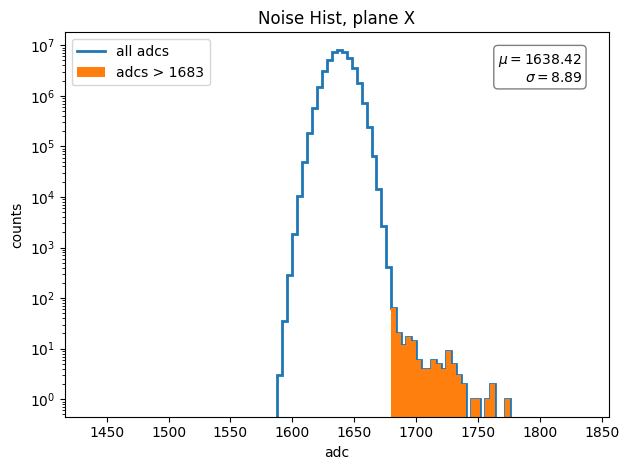

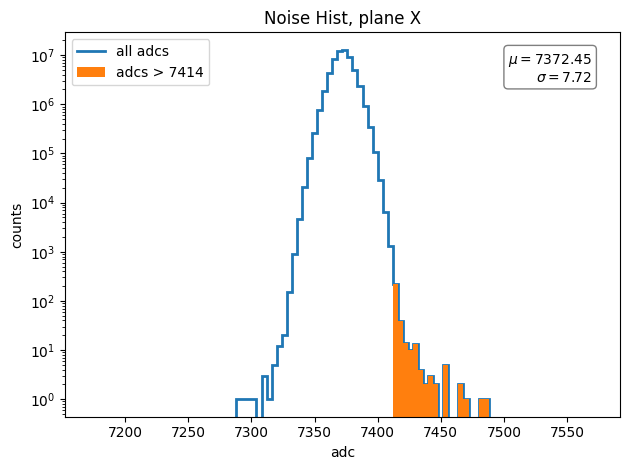

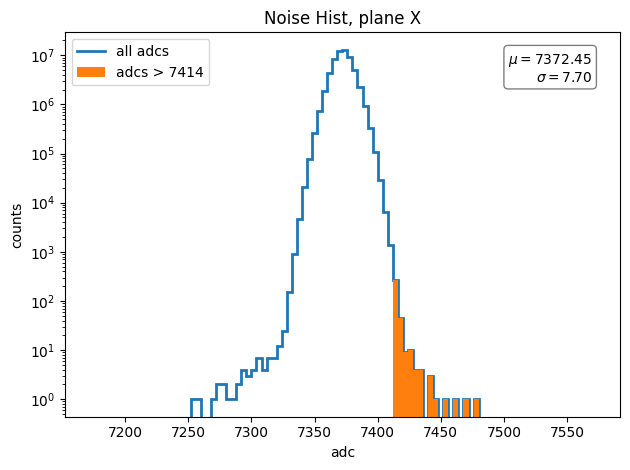

In [ ]:

_ = plot_adc_hist_right_tail(h_adc_noise_x, 45, 50)
_ = plot_adc_hist_right_tail(h_adc_noise_u, 42, 50)
_ = plot_adc_hist_right_tail(h_adc_noise_v, 42, 50)


# e-minus dataset - pre-production

INFO:TriggerPrimitivesWorkspace:Opening Trigger Primitives file
INFO:TriggerPrimitivesWorkspace:Adding processing info
INFO:TriggerPrimitivesWorkspace:Adding Event Summary data
INFO:TriggerPrimitivesWorkspace:triggerAna/event_summary found with 100 rows
INFO:TriggerPrimitivesWorkspace:Adding MCTruth data
INFO:TriggerPrimitivesWorkspace:triggerAna/mctruths found with 100 rows
INFO:TriggerPrimitivesWorkspace:Adding MCNeutrino data
INFO:TriggerPrimitivesWorkspace:triggerAna/mcneutrinos found with 0 rows
INFO:TriggerPrimitivesWorkspace:Adding MCParticles data
INFO:TriggerPrimitivesWorkspace:triggerAna/mcparticles found with 100 rows
INFO:TriggerPrimitivesWorkspace:Adding IDEs data
INFO:TriggerPrimitivesWorkspace:triggerAna/simides found with 309563 rows
INFO:TriggerPrimitivesWorkspace:tpmakerTPCSimpleThreshold__TriggerPrimitiveMaker found with 17314 rows


{
    'backtracker': {'TPAlgTPCSimpleThreshold': {'offset_U': 8, 'offset_V': 1, 'offset_X': -7}},
    'geo': {'detector': 'dunevd10kt_3view_30deg_v5_refactored_1x8x6ref'},
    'tpg': {'tpmakerTPCSimpleThreshold::TriggerPrimitiveMaker': {'threshold_tpg_plane0': 45, 'threshold_tpg_plane1': 45, 'threshold_tpg_plane2': 45, 'tool': 'TPAlgTPCSimpleThreshold'}}
}

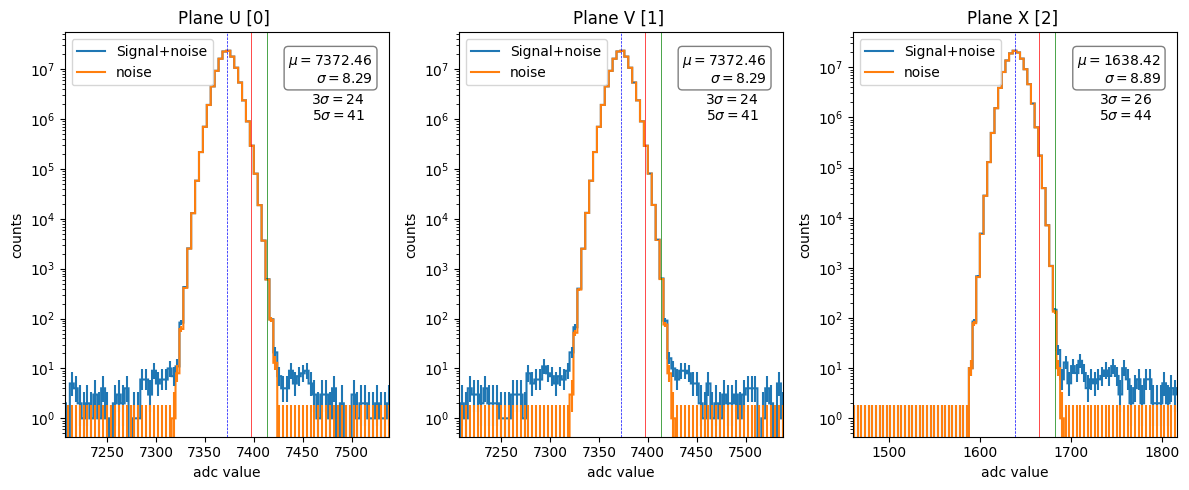

In [ ]:
dataset_info = {
    'readout_window' : 8500
}

with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.INFO):
    em_ws = workspace.TriggerPrimitivesWorkspace("../../data/vd/pre_prod/anatree_vd_eminus_hist.root", extra_info=dataset_info)

print(em_ws.info)
em_ws.add_rawdigits('../../data/vd/pre_prod/rawdigits/trigger_digits_hists_detsim_vd_eminus.root')
fig = snn.draw_signal_and_noise_adc_distros(em_ws)
fig.tight_layout()

In [29]:
h_adc_u = uproot_to_hist(ar39_ws.rawdigits_hists['ADCsPlaneU'])
h_adc_v = uproot_to_hist(ar39_ws.rawdigits_hists['ADCsPlaneV'])
h_adc_x = uproot_to_hist(ar39_ws.rawdigits_hists['ADCsPlaneX'])

h_adc_noise_u = uproot_to_hist(ar39_ws.rawdigits_hists['ADCsNoisePlaneU'])
h_adc_noise_v = uproot_to_hist(ar39_ws.rawdigits_hists['ADCsNoisePlaneV'])
h_adc_noise_x = uproot_to_hist(ar39_ws.rawdigits_hists['ADCsNoisePlaneX'])

In [30]:
print(hist_mean_std(h_adc_noise_x))
print(hist_mean_std(h_adc_noise_u))
print(hist_mean_std(h_adc_noise_v))

{0: (np.float64(1638.4217144638562), np.float64(8.889329629925317))}

{0: (np.float64(7372.458831576594), np.float64(8.289149751205114))}

{0: (np.float64(7372.458753932232), np.float64(8.28863950828878))}

In [31]:
def calc_pval_noise(h, rate_noise_tps = 2):
    sampl_period = 0.5e-6 # s
    # num_noise = int(h.GetEntries())
    num_noise = int(h.integrate(0))
    t_sampl = num_noise*sampl_period # s
    n_exp_noise_tps = rate_noise_tps*t_sampl
    p_val_noise_tps = n_exp_noise_tps/num_noise
    quantile = 1-p_val_noise_tps


    #-----
    print(f"""
---hist '{h.label}'---
num noise adcs = {num_noise}
sampling period = {t_sampl} s
target noise rate = {rate_noise_tps} Hz
num expected noise adcs = {n_exp_noise_tps}
p_val_noise = {p_val_noise_tps:.2e}
quantile = {quantile}
""")


calc_pval_noise(h_adc_noise_u, 100)
calc_pval_noise(h_adc_noise_v, 100)
calc_pval_noise(h_adc_noise_x, 100)

---hist 'ADCs on plane U'---
num noise adcs = 116314000
sampling period = 58.157 s
target noise rate = 100 Hz
num expected noise adcs = 5815.7
p_val_noise = 5.00e-05
quantile = 0.99995

---hist 'ADCs on plane X'---
num noise adcs = 116441500
sampling period = 58.220749999999995 s
target noise rate = 100 Hz
num expected noise adcs = 5822.075
p_val_noise = 5.00e-05
quantile = 0.99995

---hist 'ADCs on plane X'---
num noise adcs = 118685500
sampling period = 59.342749999999995 s
target noise rate = 100 Hz
num expected noise adcs = 5934.275
p_val_noise = 5.00e-05
quantile = 0.99995

In [ ]:

prob=np.array([0.5, 0.841, 0.977, 0.998, 0.9999685, 0.99999985, 0.9999974370002747, 0.999999, 0.999995, 0.99995])

prob_d = {
    'mean':  0.5,
    '1-sig': 0.841,
    '2-sig': 0.977, 
    '3-sig': 0.998, 
    '4-sig': 0.9999685, 
    '5-sig': 0.99999985, 
    'coll-ref': 0.9999974370002747, 
    '2 Hz': 0.999999,
    '10 Hz': 0.999995,
    '100 Hz': 0.99995
}


print_quantiles_table(h_adc_noise_x, prob_d)
print_quantiles_table(h_adc_noise_u, prob_d)
print_quantiles_table(h_adc_noise_x, prob_d)


                                                                   ADCs on plane X                                                                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ value                      ┃ mean      ┃ 1-sig     ┃ 2-sig     ┃ 3-sig     ┃ 4-sig     ┃ 5-sig     ┃ coll-ref  ┃ 2 Hz      ┃ 10 Hz     ┃ 100 Hz    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│ input prob                 │ 5.000e-01 │ 1.590e-01 │ 2.300e-02 │ 2.000e-03 │ 3.150e-05 │ 1.500e-07 │ 2.563e-06 │ 1.000e-06 │ 5.000e-06 │ 5.000e-05 │
│ x vals (adcs)              │ 1638.41   │ 1647.34   │ 1656.00   │ 1663.88   │ 1674.76   │ 1738.43   │ 1684.21   │ 1706.75   │ 1679.57   │ 1673.50   │
│ dist from mean (adcs)      │ 0.00      │ 8.93      │ 17.58     │ 25.46     │ 36.34     │ 100.01    │ 45.79     │ 68.34     │ 41.15     │ 35.08     │
│ dist from mean (68% units) │ -         │ 1.00      │ 1.97      │ 2.85      │ 4.07      │ 11.20     │ 5.13      │ 7.65      │ 4.61      │ 3.93      │
│ dist from mean (std)       │ -         │ 1.00      │ 1.98      │ 2.87      │ 4.09      │ 11.25     │ 5.15      │ 7.69      │ 4.63      │ 3.95      │
└────────────────────────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

                                                                   ADCs on plane U                                                                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ value                      ┃ mean      ┃ 1-sig     ┃ 2-sig     ┃ 3-sig     ┃ 4-sig     ┃ 5-sig     ┃ coll-ref  ┃ 2 Hz      ┃ 10 Hz     ┃ 100 Hz    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│ input prob                 │ 5.000e-01 │ 1.590e-01 │ 2.300e-02 │ 2.000e-03 │ 3.150e-05 │ 1.500e-07 │ 2.563e-06 │ 1.000e-06 │ 5.000e-06 │ 5.000e-05 │
│ x vals (adcs)              │ 7372.47   │ 7379.75   │ 7388.32   │ 7396.96   │ 7407.86   │ 7452.96   │ 7415.05   │ 7419.93   │ 7412.49   │ 7407.20   │
│ dist from mean (adcs)      │ 0.00      │ 7.28      │ 15.85     │ 24.49     │ 35.39     │ 80.49     │ 42.58     │ 47.46     │ 40.02     │ 34.73     │
│ dist from mean (68% units) │ -         │ 1.00      │ 2.18      │ 3.36      │ 4.86      │ 11.06     │ 5.85      │ 6.52      │ 5.50      │ 4.77      │
│ dist from mean (std)       │ -         │ 0.94      │ 2.05      │ 3.17      │ 4.59      │ 10.43     │ 5.52      │ 6.15      │ 5.19      │ 4.50      │
└────────────────────────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

                                                                   ADCs on plane X                                                                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ value                      ┃ mean      ┃ 1-sig     ┃ 2-sig     ┃ 3-sig     ┃ 4-sig     ┃ 5-sig     ┃ coll-ref  ┃ 2 Hz      ┃ 10 Hz     ┃ 100 Hz    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│ input prob                 │ 5.000e-01 │ 1.590e-01 │ 2.300e-02 │ 2.000e-03 │ 3.150e-05 │ 1.500e-07 │ 2.563e-06 │ 1.000e-06 │ 5.000e-06 │ 5.000e-05 │
│ x vals (adcs)              │ 1638.41   │ 1647.34   │ 1656.00   │ 1663.88   │ 1674.76   │ 1738.43   │ 1684.21   │ 1706.75   │ 1679.57   │ 1673.50   │
│ dist from mean (adcs)      │ 0.00      │ 8.93      │ 17.58     │ 25.46     │ 36.34     │ 100.01    │ 45.79     │ 68.34     │ 41.15     │ 35.08     │
│ dist from mean (68% units) │ -         │ 1.00      │ 1.97      │ 2.85      │ 4.07      │ 11.20     │ 5.13      │ 7.65      │ 4.61      │ 3.93      │
│ dist from mean (std)       │ -         │ 1.00      │ 1.98      │ 2.87      │ 4.09      │ 11.25     │ 5.15      │ 7.69      │ 4.63      │ 3.95      │
└────────────────────────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

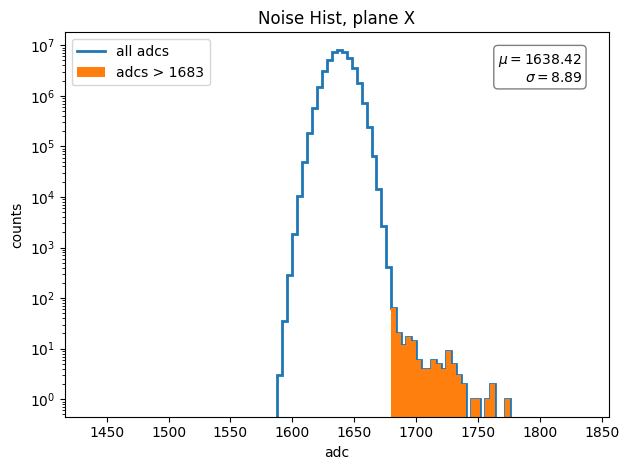

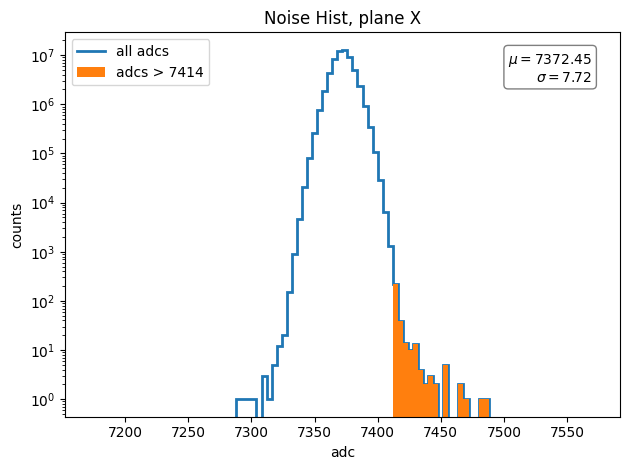

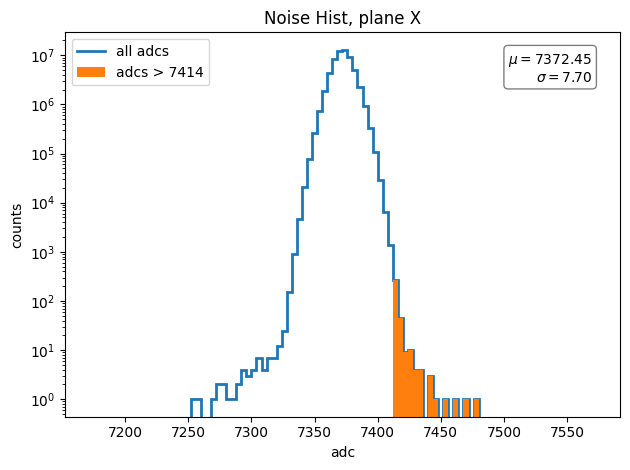

In [ ]:

_ = plot_adc_hist_right_tail(h_adc_noise_x, 45, 50)
_ = plot_adc_hist_right_tail(h_adc_noise_u, 42, 50)
_ = plot_adc_hist_right_tail(h_adc_noise_v, 42, 50)
